<a href="https://colab.research.google.com/github/rivuletsteph/TIAER/blob/main/runoff_bottom_soil_column_zarr2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Runoff from bottom of soil column (qBtmVertRunoff) from the National Water Model CONUS Retrospective Dataset channel output files in Zarr format
---
By Stephanie Brady and Emad Ahmed  
Tarleton State University    
March 14, 2023

Credits: 

[Rich Signell](https://github.com/rsignell-usgs)  
[Explore the National Water Model Reanalysis](https://nbviewer.org/gist/rsignell-usgs/78a4ce00360c65bc99764aa3e88a2493)

[James McCreight](https://github.com/jmccreight)  
[NWM v2.1 Retrospective Zarr Usage Example
](https://github.com/NCAR/rechunk_retro_nwm_v21/blob/main/notebooks/usage_example_streamflow_timeseries.ipynb)

The purpose of this notebook is to aquire the following NWM modeled channel outputs ([NWM model output data version 2.0 in Zarr format](https://registry.opendata.aws/nwm-archive/)) for one reach within the NWM:
* qBtmVertRunoff = Runoff from bottom of soil column to conceptuals groundwater basin (m3)








## To Begin
Visit the [OWP National Water Model Interactive Map](https://water.noaa.gov/map).   
This example will use ReachID `5512664`, which is the Brazos River near Glen Rose, Texas.   
Coordinates: 32.2404, -97.7120 

Import Packages

In [ ]:
!pip install s3fs
!pip install zarr

import os
import pandas as pd
import numpy as np
import s3fs
import zarr
import fsspec
import xarray as xr
import plotly.graph_objects as go
from plotly.subplots import make_subplots


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 887.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 6.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 80.4 MB/s eta 0:00:00
  Created wheel for asciitree: filename

Create notebook output folder

In [ ]:
!mkdir output
folder = os.getcwd()+'/output'

Identify the Reach ID (Refer to the section "To Begin").  
The Reach ID can be changed here.


In [ ]:
reach_id=5512664

Setup Dask.distributed the [Easy Way](https://distributed.dask.org/en/stable/quickstart.html#setup-dask-distributed-the-easy-way)

In [ ]:
from dask.distributed import Client, progress
client = Client()
client

<Client: 'tcp://127.0.0.1:42545' processes=2 threads=2, memory=12.68 GiB>

Point to the AWS CLI (Amazon Web Services Command Line Interface) where the data is storred in Zarr format.

In [ ]:
url = 's3://noaa-nwm-retro-v2-zarr-pds/'

Print the [CPU Time and Wall Time](https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=%25time#magic-time)  
Load and decode a dataset from the Zarr [store](https://docs.xarray.dev/en/stable/generated/xarray.open_zarr.html)  
Usually takes about 5 seconds

In [ ]:
%%time
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)

CPU times: user 1.35 s, sys: 247 ms, total: 1.6 s
Wall time: 4.3 s


In [ ]:
var='qBtmVertRunoff'

In [ ]:
ds[var]

<xarray.DataArray 'qBtmVertRunoff' (time: 227904, feature_id: 2729077)>
dask.array<open_dataset-ad39b74bad6e99e8af5dd541b9f9a338qBtmVertRunoff, shape=(227904, 2729077), dtype=float64, chunksize=(672, 30000), chunktype=numpy.ndarray>
Coordinates:
  * feature_id  (feature_id) int32 101 179 181 ... 1180001803 1180001804
    latitude    (feature_id) float32 dask.array<chunksize=(2729077,), meta=np.ndarray>
    longitude   (feature_id) float32 dask.array<chunksize=(2729077,), meta=np.ndarray>
  * time        (time) datetime64[ns] 1993-01-01 ... 2018-12-31T23:00:00
Attributes:
    grid_mapping:  crs
    long_name:     Runoff from bottom of soil to bucket
    units:         m3
    valid_range:   [0, 499999968]

Print the dataset description

Identify what reach or reaches for which the NWM streamflows will be downloaded.

For multiple reaches, use the syntax "reaches = np.sort(np.array([x1,x2,...]))".

In [ ]:
reach = np.sort(np.array([reach_id]))

Print the wall time.  
Extract the flow data for the specified reach and  time period.  
Typically takes about 3 mins.

In [ ]:
%%time
nwm_qBtmVertRunoff = ds.qBtmVertRunoff.sel(feature_id=reach).compute()

CPU times: user 17 s, sys: 1.68 s, total: 18.7 s
Wall time: 4min 17s


In [ ]:
nwm_qBtmVertRunoff

<xarray.DataArray 'qBtmVertRunoff' (time: 227904, feature_id: 1)>
array([[ 385.78201832],
       [ 386.44301836],
       [ 386.51901836],
       ...,
       [1055.78305015],
       [1057.74205024],
       [1055.70805014]])
Coordinates:
  * feature_id  (feature_id) int32 5512664
    latitude    (feature_id) float32 32.24
    longitude   (feature_id) float32 -97.68
  * time        (time) datetime64[ns] 1993-01-01 ... 2018-12-31T23:00:00
Attributes:
    grid_mapping:  crs
    long_name:     Runoff from bottom of soil to bucket
    units:         m3
    valid_range:   [0, 499999968]

Convert the dataset array into a dataframe.

In [ ]:
qBtmVertRunoff_df= nwm_qBtmVertRunoff.to_pandas()

In [ ]:
qBtmVertRunoff_df

feature_id               5512664
time                            
1993-01-01 00:00:00   385.782018
1993-01-01 01:00:00   386.443018
1993-01-01 02:00:00   386.519018
1993-01-01 03:00:00   386.560018
1993-01-01 04:00:00   386.906018
...                          ...
2018-12-31 19:00:00  1046.745050
2018-12-31 20:00:00  1051.375050
2018-12-31 21:00:00  1055.783050
2018-12-31 22:00:00  1057.742050
2018-12-31 23:00:00  1055.708050

[227904 rows x 1 columns]

Create Hydrograph for the Raw NWM data (hourly)

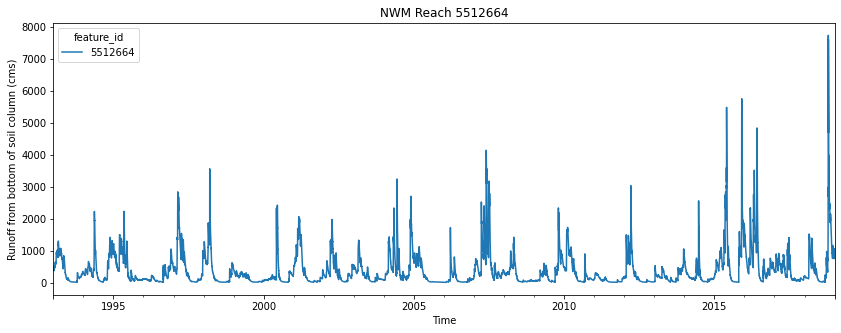

In [ ]:
qBtmVertRunoff_df.plot(figsize=(14,5), title= "NWM Reach "+ str(reach_id), xlabel="Time", ylabel="Runoff from bottom of soil column (cms)");

Create a new index column

In [ ]:
qBtmVertRunoff_df=qBtmVertRunoff_df.reset_index()

Update the column names

In [ ]:
qBtmVertRunoff_df.rename({'time': 'Date_Time', reach_id: 'NWM_cms'}, axis=1, inplace=True)

Calulate discharge in CFS



In [ ]:
qBtmVertRunoff_df["NWM_cfs"] = qBtmVertRunoff_df["NWM_cms"]*35.314666212661

In [ ]:
qBtmVertRunoff_df['Date_Time'] = qBtmVertRunoff_df['Date_Time'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago').dt.tz_localize(None)

Export wrangled NWM dataframe to a csv file

In [ ]:
qBtmVertRunoff_df

feature_id           Date_Time      NWM_cms       NWM_cfs
0          1992-12-31 18:00:00   385.782018  13623.763208
1          1992-12-31 19:00:00   386.443018  13647.106203
2          1992-12-31 20:00:00   386.519018  13649.790118
3          1992-12-31 21:00:00   386.560018  13651.238020
4          1992-12-31 22:00:00   386.906018  13663.456895
...                        ...          ...           ...
227899     2018-12-31 13:00:00  1046.745050  36965.452041
227900     2018-12-31 14:00:00  1051.375050  37128.958953
227901     2018-12-31 15:00:00  1055.783050  37284.626009
227902     2018-12-31 16:00:00  1057.742050  37353.807443
227903     2018-12-31 17:00:00  1055.708050  37281.977409

[227904 rows x 3 columns]

In [ ]:
qBtmVertRunoff_df.to_csv(folder +'/NWM_qBtmVertRunoff_data_for_' + str(reach_id)  + '.csv')

Export the table

Create the Plotly graph  
Typically takes about 10 seconds

In [ ]:
flow_fig = go.Figure()

flow_fig.add_trace(go.Scatter(x=qBtmVertRunoff_df['Date_Time'], y=qBtmVertRunoff_df['NWM_cms'], name="NWM Reach "+str(reach_id),
                         line = dict(color='blue', width=1.5)))

flow_fig.update_layout(title="Hourly runoff from bottom of soil column " +str(reach_id), 
                  yaxis_title='Runoff (cms)')

flow_fig.show()